# Extinction: A Primer

### Kristen Larson (Western Washington University)

Interstellar dust removes light of background objects by scattering and absorption.  The effectiveness with which the light is removed depends on wavelength.  Generally speaking, the dust removes short-wavelength light more than long-wavelength light; we say that background objects are *reddened* by interstellar dust. 

Let's start by defining spectral extinction as
$$
A_\lambda = +2.5\log\left( \frac{F_{\lambda 0}}{F_\lambda} \right).
$$

The extinguished flux, $F_\lambda$, is a scaled version of the orginal flux:
$$
F_\lambda = F_{\lambda 0} 10^{-0.4A_\lambda}.
$$



In [12]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u

### Exercise 1: Compare two sets of extinction curves


Let's consider, for a first example, the extinction curve from Tables 3 and 4 in Fitzpatrick (1999) and the updated version in the <code>FMunred</code> IDL procedure.  

For those who have used dereddening routines before, please note that both Fitzpatrick (1999) and <code>FMunred</code> return $A/E(B-V)$, **so always divide the output by $R(V)=A(V)/E(B-V)$ to get $A_\lambda/A(V)$**.

In [2]:
run utils/getFMext.py

In [22]:
x=np.arange(0.45,5,.01)*u.micron

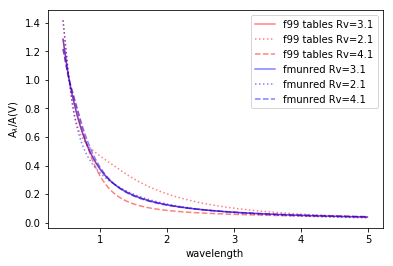

In [23]:
for model,color in [['f99 tables','r'],['fmunred','b']]:
    for Rv,line in [[3.1,'solid'],[2.1,'dotted'],[4.1,'dashed']]:
        plt.plot(x,getFMext(x,Rv,model)/Rv,color,label=model+' Rv='+str(Rv),linestyle=line,alpha=0.5)
plt.xlabel('wavelength')
plt.ylabel('A$_\lambda$/A(V)')
plt.legend(loc='best')
plt.show()

Or, if inverse wavelength is your thing... One benefit to plotting it this way is that that we require the extinction to go to zero at infinitely large wavelength in the absense of "grey" extinction, so plotted versus inverse wavelength, we can check the intercept.

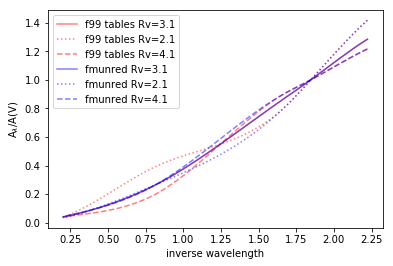

In [24]:
for model,color in [['f99 tables','r'],['fmunred','b']]:
    for Rv,line in [[3.1,'solid'],[2.1,'dotted'],[4.1,'dashed']]:
        plt.plot(1.0/x,getFMext(x,Rv,model)/Rv,color,label=model+' Rv='+str(Rv),linestyle=line,alpha=0.5)
plt.xlabel('inverse wavelength')
plt.ylabel('A$_\lambda$/A(V)')
plt.legend(loc='best')
plt.show()

Now that we have a few extinction curves, we notice quite a lot of variation in the near infrared from the tables.  This is surprising, given that photometric extinction in the NIR relatively uniform. Let's calculate photometric extinction next to see what is going on.

### Exercise 2: Calculate synthetic photometric extinction

Many astronomers think about flux in terms of photometric magnitudes,
$$
\Delta m = -2.5\log\left(\int W_\lambda F_\lambda d\lambda\right) + 2.5\log\left(\int W_\lambda F_{\rm ref} d\lambda \right).
$$

If $F_{\rm ref}$ is the flux of the zero-point, such as the star Vega for the UBVRI system, then $\Delta m = m$, the magnitude of the source.  If, on the other hand, $F_{\rm ref}$ is the flux before the dust $F_{\lambda 0}$, then $\Delta m = A$, the magnitude extinction in the band,


$$
A = -2.5\log\left(\int W_\lambda F_{\lambda 0} 10^{-0.4A_\lambda} d\lambda\right) + 2.5\log\left(\int W_\lambda F_{\lambda 0} d\lambda \right)
$$

$$
= -2.5\log\left(\frac{\int W_\lambda F_{\lambda 0} 10^{-0.4A_\lambda} d\lambda}{\int W_\lambda F_{\lambda 0} d\lambda} \right).
$$

To calculate a magnitude from a spectrum, we need the filter response $W_\lambda$, i.e. the fraction of the flux that will pass through a filter.  Because we are using a specific flux that is power per wavelength, we use $W_\lambda = \lambda S_\lambda$, where $S_\lambda$ is the photonic response and $W_\lambda$ is the energy response. See the detailed appendix in [Bessell & Murphy 2012](http://adsabs.harvard.edu/abs/2012PASP..124..140B) for more information.

There is an important point to be made here.  The expression above does not simplify any further. Strictly speaking, it is impossible to correctly calculate magnitude extinction without the original flux, even if you know the extinction curve.  If and only if the filter efficiency is constant in the band (i.e. $W_\lambda = W$) and the flux is constant in the band (i.e. $F_\lambda = F$) can we cancel these factors and convert a "theory extinction curve" into magnitudes directly.

With that caveat, we will assume in this example that any flux being extinguished in constant in the band.  With that assumtion,

$$
= -2.5\log\left(\frac{\int W_\lambda 10^{-0.4A_\lambda} d\lambda}{\int W_\lambda d\lambda} \right).
$$

In [25]:
run utils/getMag_ext.py

Let's do a sanity check.  The magnitude for $A_\lambda/A_V$ should be 1 in the $V$ band:

In [26]:
getMag_ext('V',x,getFMext(x,3.1,'fmunred')/3.1)

<Quantity 0.9758938594074276>

Looks pretty good, but now we see the size of the error we introduce by ignoring the shape of the source flux in the band.

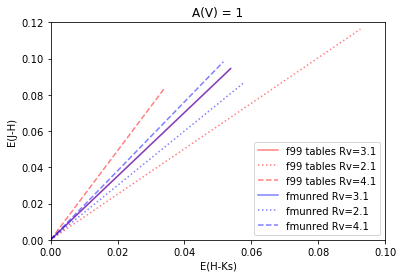

In [27]:
m = {}
for model,color in [['f99 tables','r'],['fmunred','b']]:
    for Rv,line in [[3.1,'solid'],[2.1,'dotted'],[4.1,'dashed']]:
        for band in ['J','H','Ks']:
            m[band]=getMag_ext(band,x,getFMext(x,Rv,model)/Rv)
        plt.plot([0,m['H']-m['Ks']],[0,m['J']-m['H']],color,linestyle=line,label=model+' Rv='+str(Rv),alpha=0.5)
plt.xlabel('E(H-Ks)')
plt.ylabel('E(J-H)')
plt.title('A(V) = 1')
plt.xlim([0,0.1])
plt.ylim([0,0.12])
plt.legend(loc='best')
plt.show()

The curve implied by the tables in Fitzpatrick (1999) has much more variation in the infrared than what is currently used in FMunred.  Not only is the slope E(J-H)/E(H-K) more variable, but the amount of reddening is also significantly variable.

So, we suspect a problem somewhere, and we find it by the usual method: carefully reading the paper again!  While the tables in the paper might imply non-variable spline anchors in the infrared, the text says to multiply the anchors by $R_V/3.1$.

Let's investigate what this means.  Since the routine returns $A_\lambda/E(B-V)$, dividing by 3.1 converts the output to $A_\lambda/A_V$ for the $R_V=3.1$ curve.  Multiplying by the new $R_V$ converts it back to  $A_\lambda/E(B-V)$.

Let's check with that correction to see if the two methods now agree:

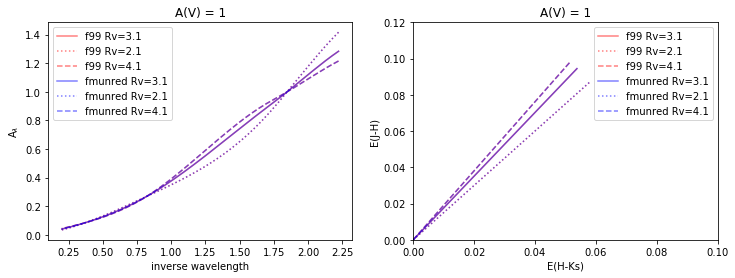

In [43]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,4))
for model,color in [['f99','r'],['fmunred','b']]:
    for Rv,line in [[3.1,'solid'],[2.1,'dotted'],[4.1,'dashed']]:
        for band in ['J','H','Ks']:
            m[band]=getMag_ext(band,x,getFMext(x,Rv,model)/Rv)
        ax1.plot(1.0/x,getFMext(x,Rv,model)/Rv,color,label=model+' Rv='+str(Rv),linestyle=line,alpha=0.5)
        ax2.plot([0,m['H']-m['Ks']],[0,m['J']-m['H']],color,linestyle=line,label=model+' Rv='+str(Rv),alpha=0.5)

ax1.set_xlabel('inverse wavelength')
ax1.set_ylabel('A$_\lambda$')
ax1.legend(loc='best')
ax1.set_title('A(V) = 1')
ax2.set_xlabel('E(H-Ks)')
ax2.set_ylabel('E(J-H)')
ax2.set_title('A(V) = 1')
ax2.set_xlim([0,0.1])
ax2.set_ylim([0,0.12])
ax2.legend(loc='best')
plt.show()

Yes, they now agree.  One interesting thing to note is that the near infrared was required to be independent of $R_V$.  Small variation in the near infrared is still present because the curve is a spline.  In 1999, there wasn't much evidence of this uniformity, just a few handful of sightlines.  So is the NIR curve really that uniform?  Stay tuned!

### Exercise 3: Magnitude extinction depends on background flux

Grace's work goes here.